#  Introduction

Here I detail some of the supplemental analyses we performed. 

##  Orientation Effects of Promoters 

The question here is do promoters in the 3'UTR affect reporter RNA stability and expression due to transcription conflicts. If this were true, orientation of the promoters would alter Reporter RNA levels in one oreintation but not the other. To address this, I will bisect my mapped reads files into two based on the orientation. This is a little tricky, but can be accomplished using sam flags (see below). After parsing, I will then make a counts matrix for all promoter annotated bins, normalize by cpm and calcualte correlation coefficients. Correlations close to 1 will indicate that orientation doesn't alter the RNA levels. Other correlations will indicate there is some effect and this could be seen on a correlation plot. 

### merge replicate bam files and separate reads into 5'-3' or 3'-5' 

This is pretty tricky to think about but is easy in execution. See the diagram below too understand why I used the particular sam flags that I did. 

![](Orientation_diagram.png)

The important thing to note is that the read 1 position is fixed on the plasmid and on the reporter RNAs, so the first read in a mate pair will always be from the 5' end of the plasmid. In this way if read 1 maps to the reverse strand, then the insert is in a 3' to 5' orientation.

I will do two samtools view commands with the -f flag (only include reads with this flag) to get the R1 and R2 for either orientation and then merge and name sort the R1 and R2 together for each orientation. 

In [ ]:
%%bash
# I already generated a merged file. Use this file in the bisection. 
# If this works, the total read count should equal that of the merged file. 

BAM_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/merged_replicates'
RESULTS_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'

#5'-3' orientation
#Read 1 - sam flag = 99
samtools view -@ 2 -f 99 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${RESULTS_DIR}/5-to-3_R1_GG-RNA.bam

#Read 2 - sam flag = 147
samtools view -@ 2 -f 147 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${RESULTS_DIR}/5-to-3_R2_GG-RNA.bam
    
#3'-5' orientation
#Read 1 - sam flag = 83
samtools view -@ 2 -f 83 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${RESULTS_DIR}/3-to-5_R1_GG-RNA.bam

#Read 2 - sam flag = 163
samtools view -@ 2 -f 163 -b -h ${BAM_DIR}/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${RESULTS_DIR}/3-to-5_R2_GG-RNA.bam

In [6]:
%%bash

BAM_DIR='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/merged_replicates'
RESULTS_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'

#Merge R1 and R2 together for only 5-3. 
samtools merge -f -@ 2 -O bam ${RESULTS_DIR}/5-to-3_R1+R2_GG-RNA.bam \
    ${RESULTS_DIR}/5-to-3_R1_GG-RNA.bam ${RESULTS_DIR}/5-to-3_R2_GG-RNA.bam

#Merge R1 and R2 together for only 3-5. 
samtools merge -f -@ 2 -O bam ${RESULTS_DIR}/3-to-5_R1+R2_GG-RNA.bam \
    ${RESULTS_DIR}/3-to-5_R1_GG-RNA.bam ${RESULTS_DIR}/3-to-5_R2_GG-RNA.bam

### Parse bins by proximal and distal

I will count reads in proximal bins and distal bins, with the hypothesis that proximal bins might be more affected by orientation. To do this, annotate the bins with chipseeker and filter by annotation. 

In [5]:
%%bash 

DIR=""

#first convert bins.saf from the activity calling analysis to a bed file. 
awk 'BEGIN{OFS=FS="\t"}{if (NR>1) print $2,$3,$4,$1,$5,"."}' ${DIR}/bins.saf > ${DIR}/bins.bed

In [ ]:
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

input <- ''

bins_anno <- annotatePeak(paste0(input,"/bins.bed"), 
                          tssRegion = c(-2000, 1000), 
                          TxDb = TxDb.Hsapiens.UCSC.hg38.knownGene)

In [ ]:
#convert anno to df and head. Note that the start is in 1-based format. I'll have to change this. 
bins_anno_df <- as.data.frame(bins_anno)

In [3]:
#Filter based on promoter annotation.
prom_bins <- dplyr::filter(bins_anno_df, stringr::str_detect(annotation, 'Promoter'))
enhc_bins <- dplyr::filter(bins_anno_df, !stringr::str_detect(annotation, 'Promoter'))

#check that this worked. Total number of rows should equal the sum of the two. This returns TRUE if correct. 
all(nrow(bins_anno_df) == (nrow(enhc_bins) + nrow(prom_bins)))

#print nrow for each to have an idea of counts. 
nrow(prom_bins)
nrow(enhc_bins)

[1] TRUE

[1] 2382142

[1] 3827480

In [7]:
library(tidyverse)
#select the first 3 columns for each to format to bed file format. 
#Before that correct the Start position which gets +1 shifted from ChIPSeeker.  
prom_bins_bed <- mutate(prom_bins, bed_start = start - 1) %>% dplyr::select(seqnames, bed_start, end)
enhc_bins_bed <- mutate(enhc_bins, bed_start = start - 1) %>% dplyr::select(seqnames, bed_start, end)

#write to new bed file in results directory. 
results <- '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'
readr::write_tsv(x = prom_bins_bed, paste0(results, "/GG_promoter_bins.bed"), col_names = FALSE)
readr::write_tsv(x = enhc_bins_bed, paste0(results, "/GG_enhancer_bins.bed"), col_names = FALSE)

### Convert 3-column bed files to SAF
We need to have bins in simple annoation format for use in featureCounts. Convert using a simple awk function. 

In [ ]:
%%bash
DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'
for i in promoter enhancer
do
    awk '{OFS=FS="\t"}; BEGIN{print "GeneID","Chr","Start","End","Strand"};{print "name_"NR,$1,$2,$3,"."}' \
    ${DIR}/GG_${i}_bins.bed > ${DIR}/GG_${i}_bins.saf
done

### Assemble Counts Matrix
Use feature counts to make three counts matricies, one for each of the two saf files. 

In [7]:
%%bash 
DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'

for i in promoter enhancer
do
    featureCounts -p -O -B --minOverlap 1 -T 3 -F SAF \
    -a ${DIR}/GG_${i}_bins.saf \
    -o ${DIR}/GG_${i}_orientation-speciefic-counts.tsv \
    ${DIR}/5-to-3_R1+R2_GG-RNA.bam \
    ${DIR}/3-to-5_R1+R2_GG-RNA.bam 
done


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 2 BAM files                                      ||
||                           o 5-to-3_R1+R2_GG-RNA.bam                        ||
||                           o 3-to-5_R1+R2_GG-RNA.bam                        ||
||                                                                            ||
||             Output file : GG_promoter_orientation-speciefic-co

### In R, calculate cpm-nromalized read count correlation and display as scatter plot
Use this formula to convert raw counts to counts per million for each bin: cpm = count / (total counts/1 million).

Total counts is the read depth for that library. 

In [3]:
%%bash 
#get read depths for directional bams. 

RESULTS_DIR='/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'

samtools flagstat -@ 2 ${RESULTS_DIR}/5-to-3_R1+R2_GG-RNA.bam
samtools flagstat -@ 2 ${RESULTS_DIR}/3-to-5_R1+R2_GG-RNA.bam

180132771 + 0 in total (QC-passed reads + QC-failed reads)
180132771 + 0 primary
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
180132771 + 0 mapped (100.00% : N/A)
180132771 + 0 primary mapped (100.00% : N/A)
180132771 + 0 paired in sequencing
90066394 + 0 read1
90066377 + 0 read2
180132771 + 0 properly paired (100.00% : N/A)
180132771 + 0 with itself and mate mapped
0 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
180405048 + 0 in total (QC-passed reads + QC-failed reads)
180405048 + 0 primary
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
180405048 + 0 mapped (100.00% : N/A)
180405048 + 0 primary mapped (100.00% : N/A)
180405048 + 0 paired in sequencing
90202533 + 0 read1
90202515 + 0 read2
180405048 + 0 properly paired (100.00% : N/A)
180405048 + 0 with itself and mate mapped
0 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different ch

5' to 3' is 180132771 reads   
3' to 5' is 180405048 reads

In [1]:
library(tidyverse)

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis/'

#read tsvs into R. Yes I realize I spelled specific wrong..  
prom_cts <- read_tsv(paste0(dir, "/GG_promoter_orientation-speciefic-counts.tsv"),
                     col_names = c("Name_ID", "Chr", "Start", "End", "Strand", "Length", "5_3", "3_5"), 
                     col_types = "cciiciii", skip = 2) %>% mutate(Start = Start-1)

enhc_cts <- read_tsv(paste0(dir, "/GG_enhancer_orientation-speciefic-counts.tsv"),
                     col_names = c("Name_ID", "Chr", "Start", "End", "Strand", "Length", "5_3", "3_5"), 
                     col_types = "cciiciii", skip = 2) %>% mutate(Start = Start-1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()



In [2]:
#calculate "per million" scale factors using a simple equation. (total reads/1 million). see above for total read counts. 

total_reads_5_3 <- 180132771
total_reads_3_5 <- 180405048

prom_5_3_scale <- total_reads_5_3 / 1e6
prom_3_5_scale <- total_reads_3_5 / 1e6

enhc_5_3_scale <- total_reads_5_3 / 1e6
enhc_3_5_scale <- total_reads_3_5 / 1e6

#Apply scale factors using simple formula. cpm = count/ per million scale factor
cpm_prom <- dplyr::mutate(prom_cts, `5_3_cpm` = `5_3` / prom_5_3_scale,
                         `3_5_cpm` = `3_5` / prom_3_5_scale)

cpm_enhc <- dplyr::mutate(enhc_cts, `5_3_cpm` = `5_3` / enhc_5_3_scale,
                         `3_5_cpm` = `3_5` / enhc_3_5_scale)
#check the dfs
head(cpm_prom)
head(cpm_enhc)

Name_ID,Chr,Start,End,Strand,Length,5_3,3_5,5_3_cpm,3_5_cpm
<chr>,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
name_1,chr1,778320,778370,.,50,16,58,0.08882337,0.3214988
name_2,chr1,778330,778380,.,50,46,97,0.25536719,0.5376790
name_3,chr1,778340,778390,.,50,72,105,0.39970517,0.5820236
name_4,chr1,778350,778400,.,50,349,206,1.93745979,1.1418749
name_5,chr1,778360,778410,.,50,358,210,1.98742293,1.1640472
name_6,chr1,778370,778420,.,50,395,298,2.19282698,1.6518385


Name_ID,Chr,Start,End,Strand,Length,5_3,3_5,5_3_cpm,3_5_cpm
<chr>,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
name_1,chr1,267895,267945,.,50,2,35,0.01110292,0.1940079
name_2,chr1,267905,267955,.,50,2,40,0.01110292,0.2217233
name_3,chr1,267915,267965,.,50,7,58,0.03886022,0.3214988
name_4,chr1,267925,267975,.,50,19,61,0.10547775,0.3381280
name_5,chr1,267935,267985,.,50,19,80,0.10547775,0.4434466
name_6,chr1,267945,267995,.,50,19,91,0.10547775,0.5044205


### Calculate Correlation

In [3]:
#Calculate correlations:
#prom first
cor.test(cpm_prom$`5_3_cpm`, cpm_prom$`3_5_cpm`, method = "spearman")
cor.test(cpm_prom$`5_3_cpm`, cpm_prom$`3_5_cpm`, method = "pearson")

#enhc next
cor.test(cpm_enhc$`5_3_cpm`, cpm_enhc$`3_5_cpm`, method = "spearman")
cor.test(cpm_enhc$`5_3_cpm`, cpm_enhc$`3_5_cpm`, method = "pearson")

Warning message in cor.test.default(cpm_prom$`5_3_cpm`, cpm_prom$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  cpm_prom$`5_3_cpm` and cpm_prom$`3_5_cpm`
S = 3.7811e+17, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.832172 



	Pearson's product-moment correlation

data:  cpm_prom$`5_3_cpm` and cpm_prom$`3_5_cpm`
t = 3198.7, df = 2382140, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9004003 0.9008799
sample estimates:
      cor 
0.9006404 


Warning message in cor.test.default(cpm_enhc$`5_3_cpm`, cpm_enhc$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  cpm_enhc$`5_3_cpm` and cpm_enhc$`3_5_cpm`
S = 2.4941e+18, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7331148 



	Pearson's product-moment correlation

data:  cpm_enhc$`5_3_cpm` and cpm_enhc$`3_5_cpm`
t = 4227.1, df = 3827478, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9073405 0.9076940
sample estimates:
      cor 
0.9075174 


### Make Scatterplots

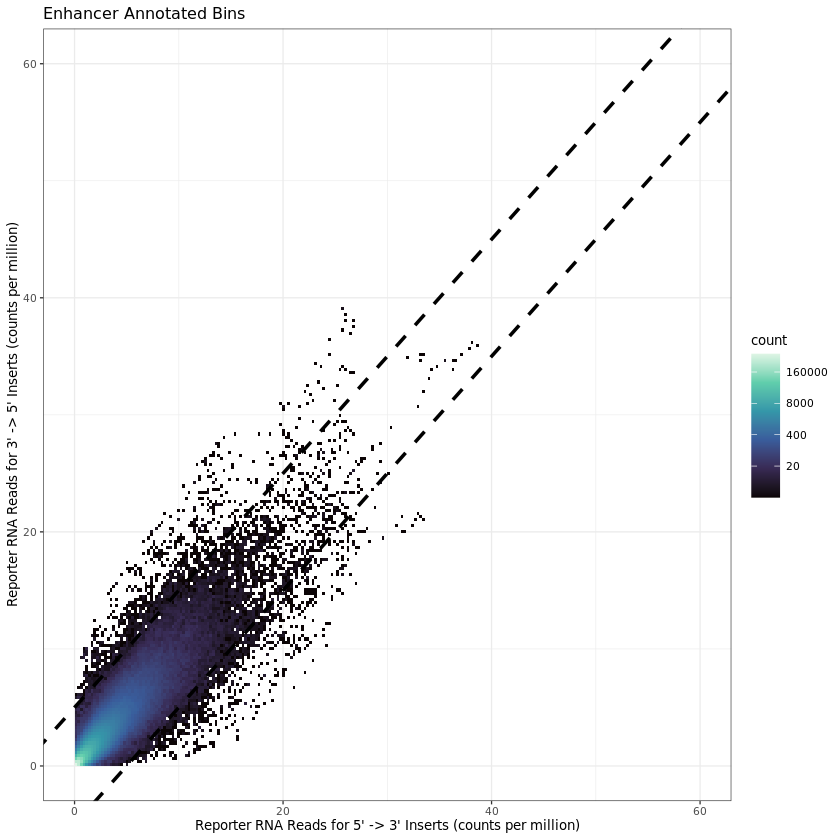

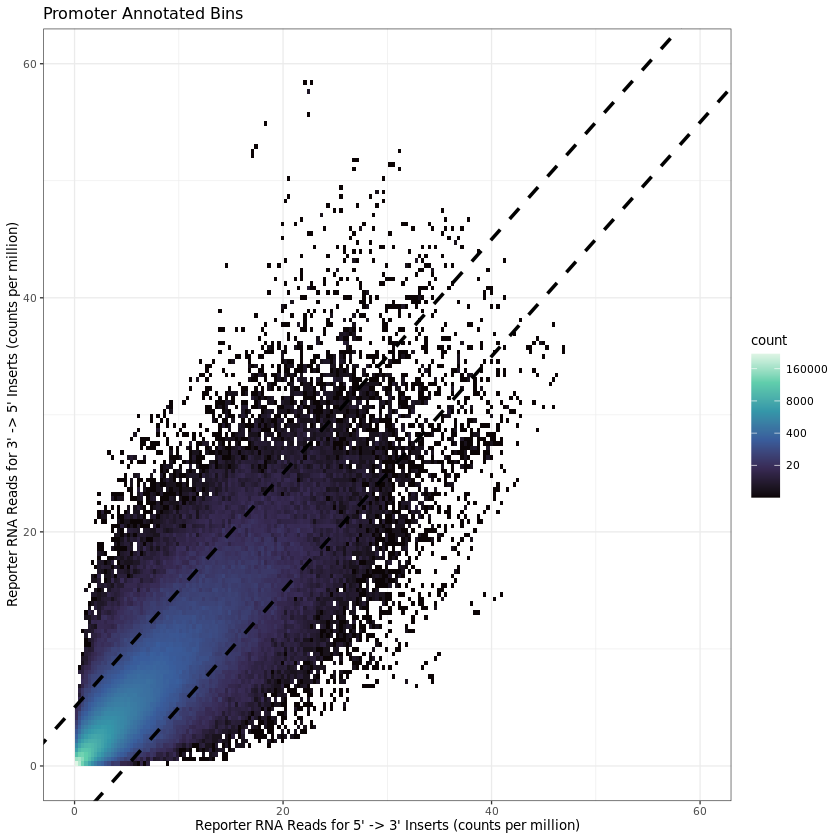

In [3]:
#Make scatterplots.
library(ggplot2)

scatter_enhc <- ggplot(cpm_enhc, aes(x=`5_3_cpm`, y=`3_5_cpm`)) +
       geom_bin2d(bins=150) +
       geom_abline(slope = 1, intercept = -5, linetype = "dashed", lwd = 1, color = "black") +
           geom_abline(slope = 1, intercept = 5, linetype = "dashed", lwd = 1, color = "black") +
       labs(x = "Reporter RNA Reads for 5' -> 3' Inserts (counts per million)", 
            y="Reporter RNA Reads for 3' -> 5' Inserts (counts per million)") +
       scale_fill_viridis_c(trans = "log", breaks = c(0, 20, 400, 8000, 160000), option = "mako") +
       ggtitle("Enhancer Annotated Bins") +
       theme_bw(base_size = 8) +
       coord_cartesian(xlim = c(0, 60), ylim = c(0, 60))
       
scatter_prom <- ggplot(cpm_prom, aes(x=`5_3_cpm`, y=`3_5_cpm`)) +
       geom_bin2d(bins=150) +
       geom_abline(slope = 1, intercept = -5, linetype = "dashed", lwd = 1, color = "black") +
           geom_abline(slope = 1, intercept = 5, linetype = "dashed", lwd = 1, color = "black") +
       labs(x = "Reporter RNA Reads for 5' -> 3' Inserts (counts per million)", 
            y="Reporter RNA Reads for 3' -> 5' Inserts (counts per million)") +
       scale_fill_viridis_c(trans = "log", breaks = c(0, 20, 400, 8000, 160000), option = "mako") +
       ggtitle("Promoter Annotated Bins") +
       theme_bw(base_size = 8) +
       coord_cartesian(xlim = c(0, 60), ylim = c(0, 60))

scatter_enhc
scatter_prom

#Save as pdf.
ggsave(plot = scatter_enhc, paste0(dir,"/enhancer_correlation.pdf"), width = 4, height = 4)
ggsave(plot = scatter_prom, paste0(dir,"/prom_correlation.pdf"), width = 4, height = 4)

### Repeat for active and silent bins

In [7]:
#read in active and silent bins and intersect with these. 
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink'

#read tsvs into R. Yes I realize I spelled specific wrong..  
active_bins <- read_tsv(paste0(dir, "/active_bins.bed"),
                       col_names = c("Chr", "Start", "End", "Bin_ID", "Score", "Strand"), 
                       col_types = "ciicnf")

silent_bins <- read_tsv(paste0(dir, "/silent_bins.bed"),
                       col_names = c("Chr", "Start", "End", "Bin_ID", "Score", "Strand"), 
                       col_types = "ciicnf")

In [8]:
#inner_join promoter counts to active and silent seperately.
prom_act <- inner_join(cpm_prom, active_bins, by = c("Chr"="Chr", "Start"="Start", "End"="End"))
prom_sil <- inner_join(cpm_prom, silent_bins, by = c("Chr"="Chr", "Start"="Start", "End"="End"))
enhc_act <- inner_join(cpm_enhc, active_bins, by = c("Chr"="Chr", "Start"="Start", "End"="End"))
enhc_sil <- inner_join(cpm_enhc, silent_bins, by = c("Chr"="Chr", "Start"="Start", "End"="End"))

In [9]:
#Calculate correlations using a function I wrote:
TH_correlation <- function (df) {
    print("number of regions")
    print(nrow(df))
    print(cor.test(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"))
    print(cor.test(df$`5_3_cpm`, df$`3_5_cpm`, method = "pearson"))
}

print("Active Promoter")
TH_correlation(df = prom_act)
print("Silent Promoter")
TH_correlation(df = prom_sil)
print("Active Enhancer")
TH_correlation(df = enhc_act)
print("Silent Enhancer")
TH_correlation(df = enhc_sil)


[1] "Active Promoter"
[1] "number of regions"
[1] 124227


Warning message in cor.test.default(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$`5_3_cpm` and df$`3_5_cpm`
S = 3.3434e+13, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8953607 


	Pearson's product-moment correlation

data:  df$`5_3_cpm` and df$`3_5_cpm`
t = 747.9, df = 124225, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9035679 0.9055891
sample estimates:
      cor 
0.9045836 

[1] "Silent Promoter"
[1] "number of regions"
[1] 296016


Warning message in cor.test.default(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$`5_3_cpm` and df$`3_5_cpm`
S = 7.7716e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8202305 


	Pearson's product-moment correlation

data:  df$`5_3_cpm` and df$`3_5_cpm`
t = 730.16, df = 296014, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8005767 0.8031489
sample estimates:
      cor 
0.8018666 

[1] "Active Enhancer"
[1] "number of regions"
[1] 127668


Warning message in cor.test.default(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$`5_3_cpm` and df$`3_5_cpm`
S = 7.9136e+13, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7718199 


	Pearson's product-moment correlation

data:  df$`5_3_cpm` and df$`3_5_cpm`
t = 794.21, df = 127666, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9110320 0.9128788
sample estimates:
    cor 
0.91196 

[1] "Silent Enhancer"
[1] "number of regions"
[1] 43721


Warning message in cor.test.default(df$`5_3_cpm`, df$`3_5_cpm`, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$`5_3_cpm` and df$`3_5_cpm`
S = 2.5449e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8172913 


	Pearson's product-moment correlation

data:  df$`5_3_cpm` and df$`3_5_cpm`
t = 312.53, df = 43719, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8282258 0.8340227
sample estimates:
      cor 
0.8311468 



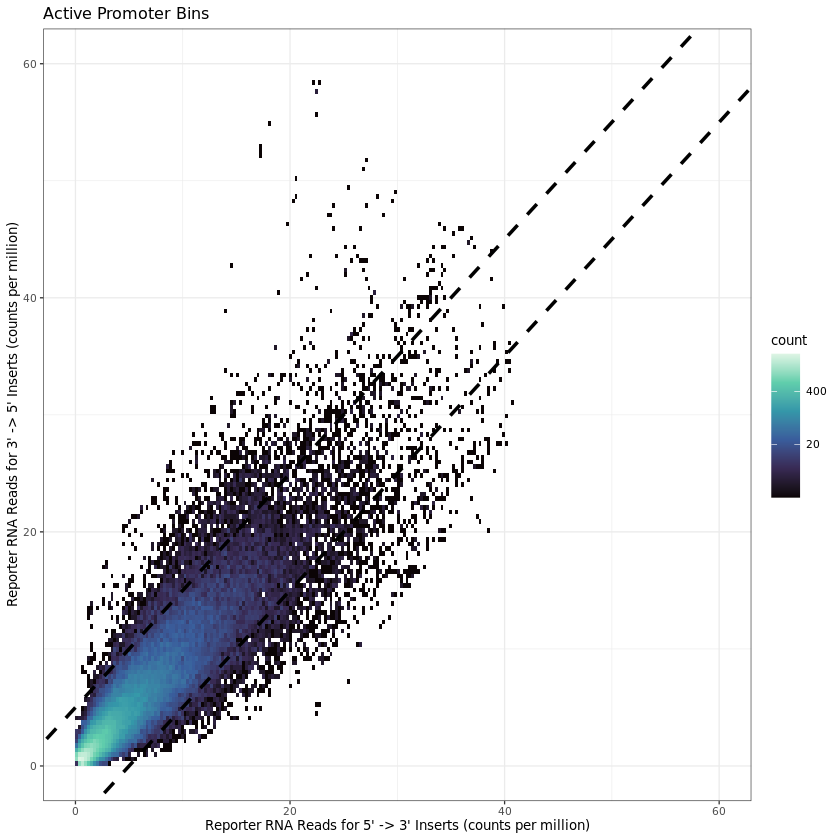

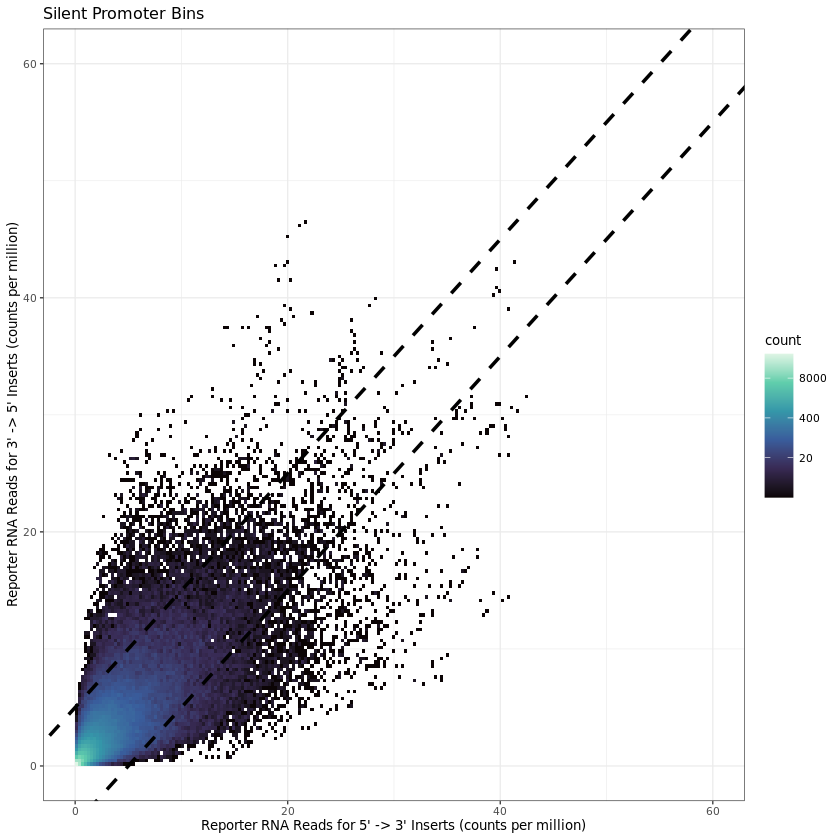

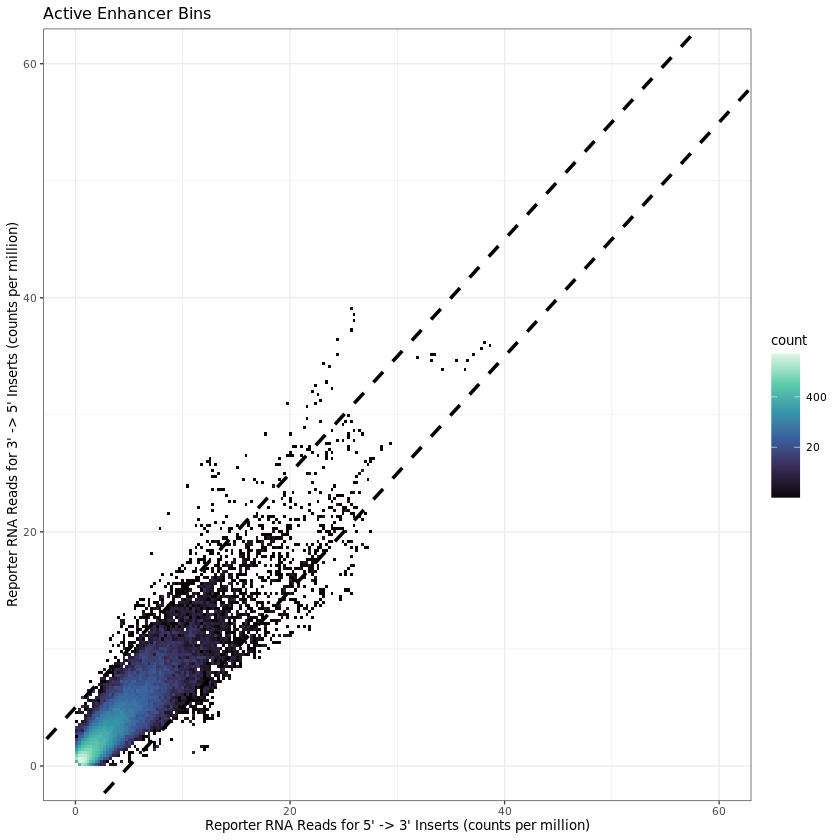

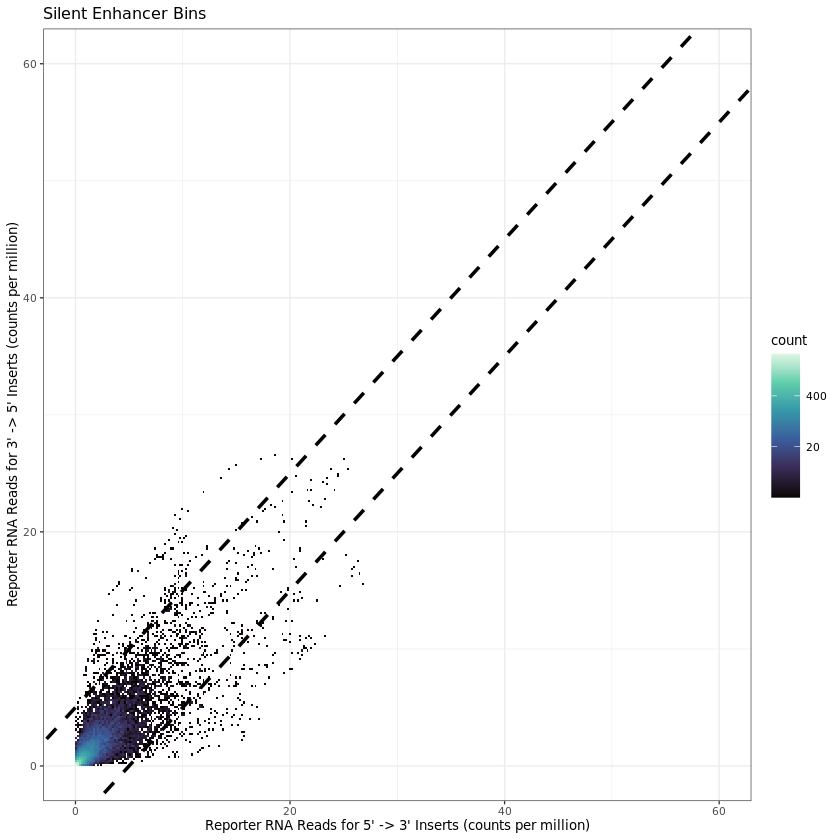

In [13]:
#Make scatterplots.
library(ggplot2)

#my function
TH_scatterplot <- function(df, title, viridis_option = "viridis") {
    p <- ggplot(df, aes(x=`5_3_cpm`, y=`3_5_cpm`)) +
           geom_bin2d(bins=150) +
           geom_abline(slope = 1, intercept = -5, linetype = "dashed", lwd = 1, color = "black") +
           geom_abline(slope = 1, intercept = 5, linetype = "dashed", lwd = 1, color = "black") +
           labs(x = "Reporter RNA Reads for 5' -> 3' Inserts (counts per million)", 
                y="Reporter RNA Reads for 3' -> 5' Inserts (counts per million)") +
           scale_fill_viridis_c(trans = "log", breaks = c(0, 20, 400, 8000, 160000), option = viridis_option) +
           ggtitle(title) +
           theme_bw(base_size = 8) +
           coord_cartesian(xlim = c(0, 60), ylim = c(0, 60))
    return(p)
}

#run function
prom_act_p <- TH_scatterplot(prom_act, title = "Active Promoter Bins", viridis_option = "mako")
prom_sil_p <- TH_scatterplot(prom_sil, title = "Silent Promoter Bins", viridis_option = "mako")
enhc_act_p <- TH_scatterplot(enhc_act, title = "Active Enhancer Bins", viridis_option = "mako")
enhc_sil_p <- TH_scatterplot(enhc_sil, title = "Silent Enhancer Bins", viridis_option = "mako")

#view plots
prom_act_p
prom_sil_p
enhc_act_p 
enhc_sil_p 

#Save as pdfs.
dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'
ggsave(plot = prom_act_p, paste0(dir,"/active-promoter_correlation.pdf"), width = 4, height = 4)
ggsave(plot = prom_sil_p, paste0(dir,"/silent-promoter_correlation.pdf"), width = 4, height = 4)
ggsave(plot = enhc_act_p, paste0(dir,"/active-enhancer_correlation.pdf"), width = 4, height = 4)
ggsave(plot = enhc_sil_p, paste0(dir,"/silent-enhancer_correlation.pdf"), width = 4, height = 4)

### Count bins with orientation bias

We arbitrarily say that > 2.5 normalized count difference is "orientation bias. Ask how many bins have orientation bias. 

In [14]:
#total number of bins in each
nrow(cpm_prom)
nrow(cpm_enhc)
nrow(prom_act)
nrow(prom_sil)
nrow(enhc_act)
nrow(enhc_sil)

#This counts bins when the difference between orientations is 5 counts or greater. 
filter(cpm_prom, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow()
filter(cpm_enhc, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow()
filter(prom_act, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow()
filter(prom_sil, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow()
filter(enhc_act, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow()
filter(enhc_sil, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow()

#This determines proportion of bins when the difference between orientations is 2.5 counts or greater. 
filter(cpm_prom, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow() / nrow(cpm_prom)
filter(cpm_enhc, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow() / nrow(cpm_enhc)
filter(prom_act, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow() / nrow(prom_act)
filter(prom_sil, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow() / nrow(prom_sil)
filter(enhc_act, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow() / nrow(enhc_act)
filter(enhc_sil, abs(`5_3_cpm` - `3_5_cpm`) > 5) %>% nrow() / nrow(enhc_sil)

[1] 2382142

[1] 3827480

[1] 124227

[1] 296016

[1] 127668

[1] 43721

[1] 34549

[1] 2799

[1] 5391

[1] 10886

[1] 823

[1] 536

[1] 0.01450333

[1] 0.0007312906

[1] 0.04339636

[1] 0.03677504

[1] 0.006446408

[1] 0.01225955

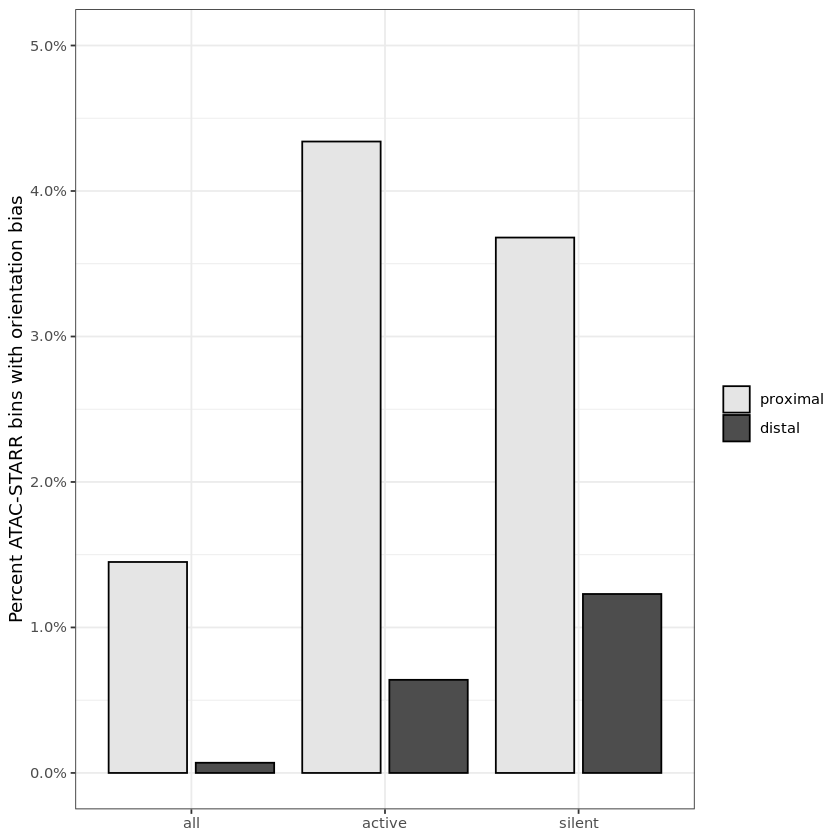

In [17]:
library(ggplot2)
df <- data.frame(value = c(0.0145, 0.0007, 0.0434, 0.0368, 0.0064, 0.0123),
                 element_type = c("proximal", "distal", "proximal", "proximal", "distal", "distal"),
                 regulatory_state = c("all", "all", "active", "silent", "active", "silent"))

df$regulatory_state <- factor(df$regulatory_state, levels = c("all", "active", "silent"))
df$element_type <- factor(df$element_type, levels = c("proximal", "distal"))

p <- ggplot(df, aes(x=regulatory_state, y=value, fill=element_type)) + 
    geom_col(position = "dodge2", color="black") +
    scale_fill_manual(values = c("grey90", "grey30")) +
    scale_y_continuous(labels = scales::percent) +
    ylab("Percent ATAC-STARR bins with orientation bias") +
    theme_bw() +
    theme(legend.title = element_blank(), axis.title.x = element_blank()) +
    coord_cartesian(ylim = c(0, 0.05))

p

res_dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/orientation-analysis'
ggsave(p, filename = paste0(res_dir, "/orientation_bias_bar.pdf"), device = cairo_pdf, width = 4, height = 2)

## Differences in number of active regions between ATAC-STARR and HiDRA

With the first point answered, let's move on to the second analysis: 

We wanted to investigate the differences in number of active regions called between ATAC-STARR and hiDRA. Download HiDRA fastqs and process in a similar fashion as we do. Then call active regions to see how the number called compares with 3 or 5 replicates. 

### Download and process HiDRA data

#### Download fastqs from SRA

The GEO number is GSE104001. They have 5 replicates for RNA and DNA. Each replicate has 4 runs. 

DNA Rep1 - SRR6050484 | SRR6050485 | SRR6050486	| SRR6050487  
DNA Rep2 - SRR6050488 | SRR6050489 | SRR6050490	| SRR6050491  
DNA Rep3 - SRR6050492 | SRR6050493 | SRR6050494	| SRR6050495   
DNA Rep4 - SRR6050496 | SRR6050497 | SRR6050498	| SRR6050499   
DNA Rep5 - SRR6050500 | SRR6050501 | SRR6050502	| SRR6050503   

RNA Rep1 - SRR6050504 | SRR6050505 | SRR6050506	| SRR6050507  
RNA Rep2 - SRR6050508 | SRR6050509 | SRR6050510 | SRR6050511   
RNA Rep3 - SRR6050512 | SRR6050513 | SRR6050514 | SRR6050515   
RNA Rep4 - SRR6050516 | SRR6050517 | SRR6050518 | SRR6050519   
RNA Rep5 - SRR6050520 | SRR6050521 | SRR6050522 | SRR6050523  

In [ ]:
%%bash 
cd /data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data/fastq

module load SRA-Toolkit/2.9.6-1-centos_linux64

#I'm using code from here: https://edwards.sdsu.edu/research/fastq-dump/
for ID in {6050484..6050523}
do
fastq-dump --gzip --readids --read-filter pass --dumpbase --split-3 --clip SRR${ID}
done

#### Process fastqs to filtered bams

Now we need to trim and map the hiDRA reads to hg38. I did this in the same fashion as my data. Therefore check the 1_read-processing section for an example of how I processed fastq files. 

#### Merge Technical Replicates

With the processing done, check the QC and then proceed to merge technical replicate files into biological replicates (for example 1A-1D).

In [ ]:
%%bash 
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'
#merge technical replicates for DNA:
for i in filtered unique
do
    for j in DNA_Rep_1 DNA_Rep_2 DNA_Rep_3 DNA_Rep_4 DNA_Rep_5 
    do
        #Merge reps and pos-sort. Both merge and sort require ouput name as first file for some stupid reason. 
        # Here I use "-" to pipe to sort. 
        samtools merge -@ 3 - \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}A.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}B.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}C.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}D.${i}.pos-sorted.bam | \
        samtools sort -@ 3 -o ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}.pos-sorted.${i}.bam -
        #make an n-sorted version
        samtools sort -n -@ 3 -o ${HIDRA}/data/bams/n-sorted/HiDRA_${j}.n-sorted.${i}.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}.pos-sorted.${i}.bam
        done
done

In [ ]:
%%bash 
HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'
#merge technical replicates for RNA:
for i in filtered unique
do
    for j in RNA_Rep_1 RNA_Rep_2 RNA_Rep_3 RNA_Rep_4 RNA_Rep_5 
    do
        #Merge reps and pos-sort. Both merge and sort require ouput name as first file for some stupid reason. 
        # Here I use "-" to pipe to sort. 
        samtools merge -@ 3 - \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}A.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}B.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}C.${i}.pos-sorted.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}D.${i}.pos-sorted.bam | \
        samtools sort -@ 3 -o ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}.pos-sorted.${i}.bam -
        #make an n-sorted version
        samtools sort -n -@ 3 -o ${HIDRA}/data/bams/n-sorted/HiDRA_${j}.n-sorted.${i}.bam \
        ${HIDRA}/data/bams/pos-sorted/HiDRA_${j}.pos-sorted.${i}.bam
        done
done

#move tech reps to a new folder to clean up. 
for sort in pos-sorted n-sorted 
do
    mv ${HIDRA}/data/bams/${sort}/*A.* ${HIDRA}/data/bams/${sort}/tech-reps
    mv ${HIDRA}/data/bams/${sort}/*B.* ${HIDRA}/data/bams/${sort}/tech-reps
    mv ${HIDRA}/data/bams/${sort}/*C.* ${HIDRA}/data/bams/${sort}/tech-reps
    mv ${HIDRA}/data/bams/${sort}/*D.* ${HIDRA}/data/bams/${sort}/tech-reps
done    

### Fix readname issue
Fastq-dump adds a read 1 and read 2 identifier to the read names (see first file above). I used an awesome awk command that we wrote to remove the last two digits of the first column to correct the bam files.

In [14]:
#Test the awk command to see if it works
samtools view ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.bam | head -n 6

samtools view ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.bam | \
awk 'BEGIN{OFS=FS="\t"}{$1=substr($1,1,length($1)-2);print}' - | head -n 6

SRR6050484.1.1	99	chr13	40652319	42	36M	=	40652640	357	TCTGTCGCCCAGGCTGGAGTGTAGCGGCACGATCTC	AAAAAEEEEEEEEEEEEEEEEEEEEEEEAEEEEEEE	AS:i:-5	XN:i:0	XM:i:1	XO:i:0	XG:i:0	NM:i:1	MD:Z:29A6	YS:i:0	YT:Z:CP
SRR6050484.1.2	147	chr13	40652640	42	36M	=	40652319	-357	CAACTCTATCCTGAAGGTTAGAGAAGAGAAAAAACC	EEEEEEEEEEEEEEEEEAEEEEEEEEEEEEEAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:36	YS:i:-5	YT:Z:CP
SRR6050484.4.1	99	chr3	42883015	42	37M	=	42883403	424	GTCTCTGACTTGCTATGTTAGTGATTTTATGCACCCA	AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEAEAAE	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:37	YS:i:0	YT:Z:CP
SRR6050484.4.2	147	chr3	42883403	42	36M	=	42883015	-424	GTTTCCCCATACTGTTCTCGTGGTAGTGAGTAATTC	EEEEEEEEEEEEEEEEEEEEAEEEEEAEEEEAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:36	YS:i:0	YT:Z:CP
SRR6050484.8.1	83	chr3	44861480	42	36M	=	44861196	-320	AGGCATCTCTTGGTCCGGCGGTCCTCAGGCTGGAGG	EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAAAAA	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:36	YS:i:0	YT:Z:CP
SRR6050484.8.2	163	chr

In [34]:
#execute this script to fix the issue for all hiDRA files:
cat HiDRA_fixbam.slrm

#!/bin/bash
##SBATCH --mail-user=tyler.j.hansen@vanderbilt.edu
##SBATCH --mail-type=ALL
##SBATCH --nodes=1
##SBATCH --ntasks=1
##SBATCH --cpus-per-task=6
##SBATCH --time=24:00:00
##SBATCH --mem=32G

module restore tools 

#now make a loop to process the bams. Make sure to add back the header. 

for FILE in DNA_Rep_1 DNA_Rep_2 DNA_Rep_3 DNA_Rep_4 DNA_Rep_5 RNA_Rep_1 RNA_Rep_2 RNA_Rep_3 RNA_Rep_4 RNA_Rep_5
do
    for TYPE in filtered unique
    do
        #define files:
        HIDRA='/data/hodges_lab/ATAC-STARR_V2/results/NAR_revisions/hidra-vs-AS_active-number/hiDRA_data'
        IN=${HIDRA}'/data/bams/n-sorted/HiDRA_'${FILE}'.n-sorted.'${TYPE}'.bam'
        OUT=${HIDRA}'/data/bams/n-sorted/HiDRA_'${FILE}'.n-sorted.'${TYPE}'.corrected.bam'
        
        #extract header. 
        samtools view -@ 6 -H $IN > tmp.header.sam
        
        #fix reads.
        samtools view -@ 6 $IN | awk 'BEGIN{OFS=FS="\t"}{$1=substr($1,1,length($1)-2);print}' - > tmp.reads.sam 
        
        #rehe

### Assign HiDRA reads to our sliding window bins

In [3]:
%%bash 
HIDRA='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'
AS='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink'

featureCounts -p -O -B --minOverlap 1 -T 4 -F SAF -G /data/hodges_lab/hg38_genome/hg38.fa \
        -a ${AS}/bins.saf  \
        -o ${HIDRA}/data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates_in-AS-bins.tsv \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_1.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_2.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_3.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_4.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_DNA_Rep_5.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_1.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_2.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_3.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_4.n-sorted.filtered.corrected.bam \
        ${HIDRA}/data/bams/n-sorted/HiDRA_RNA_Rep_5.n-sorted.filtered.corrected.bam 


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 10 BAM files                                     ||
||                           o HiDRA_DNA_Rep_1.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_2.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_3.n-sorted.filtered.correcte ... ||
||                           o HiDRA_DNA_Rep_4.n-sorted.filtered.

### Differential Analysis

In [1]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates_in-AS-bins.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% 
                        column_to_rownames(var = "Bin_ID") %>% filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA","DNA","DNA",
            "RNA","RNA","RNA","RNA","RNA")

RNames <- c("DNA1","DNA2","DNA3","DNA4","DNA5",
            "RNA1","RNA2","RNA3","RNA4","RNA5")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(2)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

save(dds, file = paste0(dir, "/results/hiDRA_AS-bins_dds.Rdata"))
save(res, file = paste0(dir, "/results/hiDRA_AS-bins_res.Rdata"))

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



In [2]:
#I had written this for something else, so I used this function to filter active bins. 
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/hiDRA_active_", padj_val, ".bed"), 
              col_names = FALSE)
    return(active_bed)
}

active_1 <- filter_padj(res_df, cts_df, padj_val = 0.1)

In [ ]:
%%bash
#merge overlapping bins
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'

for val in 0.1
do
    bedtools merge -i ${dir}/results/hiDRA_active_${val}.bed > \
    ${dir}/results/hiDRA_active_${val}.merged-bins.bed  
done

### Redo but using only 3 HiDRA replicates

In [2]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(apeglm)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data/'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "data/cts/HiDRA_counts_bin-method_50bp-bins_with-duplicates_in-AS-bins.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Convert cts to a matrix of integer counts with row names represented by Peak_ID.
cts_matrix <- dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length, -DNA4, -DNA5, -RNA4, -RNA5) %>% 
                        column_to_rownames(var = "Bin_ID") %>% filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA",
            "RNA","RNA","RNA")

RNames <- c("DNA1","DNA2","DNA3",
            "RNA1","RNA2","RNA3")

coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_matrix))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_matrix, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

write_tsv(res_df, paste0(dir, "/results/hiDRA_results_AS-bins_3-reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



In [3]:
filter_padj <- function(res_df, cts_df, padj_val) {
    active <- filter(res_df, padj < padj_val) %>% filter(log2FoldChange > 0) 
    active_bed <- left_join(active, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
               dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% 
               dplyr::arrange(Chr, Start, End)
    write_tsv(active_bed, paste0(dir, "/results/hiDRA_active_3-reps", padj_val, ".bed"), 
              col_names = FALSE)
    return(active_bed)
}

active_1 <- filter_padj(res_df, cts_df, padj_val = 0.1)

In [ ]:
%%bash

dir='/data/hodges_lab/ATAC-STARR_B-cells/results/hidra-vs-AS_active-regions/hiDRA_data'

for val in 0.1
do
    bedtools merge -i ${dir}/results/hiDRA_active_3-reps${val}.bed > \
    ${dir}/results/hiDRA_active_3-reps${val}.merged-bins.bed  
done

### Plot Region Counts

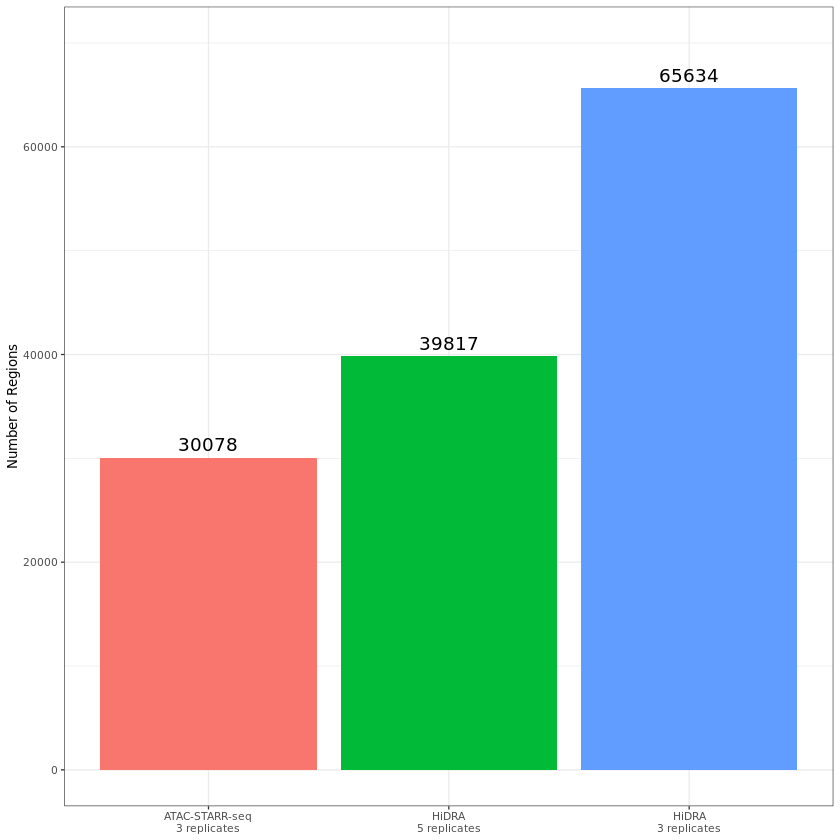

In [3]:
library(ggplot2)

df <- data.frame(Group = c("ATAC-STARR-seq\n3 replicates", "HiDRA\n5 replicates","HiDRA\n3 replicates"),
  value = c(30078,39817,65634))

df$Group <- factor(df$Group, levels = c("ATAC-STARR-seq\n3 replicates", "HiDRA\n5 replicates","HiDRA\n3 replicates"))

p <- ggplot(df, aes(x=Group, y=value, fill = Group)) +
  geom_col() +
  geom_text(aes(label = value), vjust = -0.5) +
  theme_bw(base_size = 8) + 
  ylab("Number of Regions") +
  theme(legend.position = "none", axis.title.x = element_blank()) +
  coord_cartesian(ylim = c(0, 70000))
p

res_dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/NAR_paper_figures'
ggsave(p, filename = paste0(res_dir, "/hidra_reps_bar.pdf"), device = cairo_pdf, width = 3, height = 3)

## Psudeo-replicates

To figure out how increasing number of replicates influences region count, I will make 5 pseudo-replicates from my data. And compare active region counts when adding replicates. I'll compare 2,3,4,5 replicates. 

### Generate psuedo-reps

In [ ]:
%%bash
#using merged bams, subsample each into 5 pseduo replicates. 
#Change the seed value for every subsample and extract 20% of reads. -s [INT.frac]. INT is seed.
# Samtools documentation: 
#   -s FLOAT subsample reads (given INT.FRAC option value, 0.FRAC is the
#   fraction of templates/read pairs to keep; INT part sets seed)

AS='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams/merged_replicates'

for rep in 1 2 3 4 5
do
    #DNA
    samtools view -@ 4 -s ${rep}.2 -b ${AS}/merged_replicates/GM12878inGM12878_DNA_merged.filtered.n-sorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.unsorted.bam
    #n-sort
    samtools sort -@ 4 -n ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.unsorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_DNA_${rep}.filtered.n-sorted.bam
done

In [12]:
%%bash

AS='/data/hodges_lab/ATAC-STARR_B-cells/data/ATAC-STARR/bams'

for rep in 1 2 3 4 5
do
    #RNA
    samtools view -@ 4 -s ${rep}.2 -b ${AS}/merged_replicates/GM12878inGM12878_RNA_merged.filtered.pos-sorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_RNA_${rep}.filtered.unsorted.bam
    #n-sort
    samtools sort -@ 4 -n ${AS}/pseudo_replicates/GM12878inGM12878_RNA_${rep}.filtered.unsorted.bam > \
    ${AS}/pseudo_replicates/GM12878inGM12878_RNA_${rep}.filtered.n-sorted.bam
done

[bam_sort_core] merging from 28 files and 4 in-memory blocks...
[bam_sort_core] merging from 28 files and 4 in-memory blocks...
[bam_sort_core] merging from 28 files and 4 in-memory blocks...
[bam_sort_core] merging from 28 files and 4 in-memory blocks...
[bam_sort_core] merging from 28 files and 4 in-memory blocks...


### Make counts matrix

In [1]:
%%bash
#run feature counts with all 5 pseduo replicates.

OUT='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'
AS='/data/hodges_lab/ATAC-STARR_B-cells'

featureCounts -p -O -B --minOverlap 1 -T 8 -F SAF -G /data/hodges_lab/hg38_genome/hg38.fa \
        -a ${AS}/data/ATAC-STARR/regulatory_regions/GM12878inGM12878_0.1_3-reps_no-counts_no-shrink/bins.saf \
        -o ${OUT}/counts_psuedo-replicates_all.tsv \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_1.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_2.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_3.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_4.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_DNA_5.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_1.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_2.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_3.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_4.filtered.n-sorted.bam \
        ${AS}/data/ATAC-STARR/bams/pseudo_replicates/GM12878inGM12878_RNA_5.filtered.n-sorted.bam 


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 10 BAM files                                     ||
||                           o GM12878inGM12878_DNA_1.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_DNA_2.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_DNA_3.filtered.n-sorted.bam   ||
||                           o GM12878inGM12878_DNA_4.filtered.n-

### Differential analysis

In [2]:
#Load required libraries
library(DESeq2)
library(tidyverse)
library(BiocParallel)
register(MulticoreParam(4))

dir <- '/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

#Read in counts matrix
cts_df <- read_tsv(paste0(dir, "/counts_psuedo-replicates_all.tsv"),
                   col_names = c("Bin_ID","Chr","Start","End","Strand","Length",
                                 "DNA1","DNA2","DNA3","DNA4","DNA5",
                                 "RNA1","RNA2","RNA3","RNA4","RNA5"), 
                   col_types = "cciiciiiiiiiiiii", skip = 2)

#Clean df. Make Bin_ID the rownames.
cts_clean <- dplyr::select(cts_df, -Chr,-Start,-End,-Strand,-Length) %>% 
        column_to_rownames(var = "Bin_ID")

#create 4 different matricies that each represent a differnt nubmer of replicates. 
cts_2 <- dplyr::select(cts_clean, DNA1, DNA2, RNA1, RNA2) %>% 
        filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()
        
cts_3 <- dplyr::select(cts_clean, DNA1, DNA2, DNA3, RNA1, RNA2, RNA3) %>% 
        filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()
        
cts_4 <- dplyr::select(cts_clean, DNA1, DNA2, DNA3, DNA4, RNA1, RNA2, RNA3, RNA4) %>% 
        filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()
        
cts_5 <- cts_clean %>% filter_if(is.numeric, all_vars((.) != 0)) %>% as.matrix()

#### Two pseudo replicates

In [4]:
register(MulticoreParam(4))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","RNA","RNA")
RNames <- c("DNA1","DNA2",
            "RNA1","RNA2")
coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_2))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_2, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#extract active regions using different padj filters
active_2 <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

active_bed_2 <- left_join(active_2, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% dplyr::arrange(Chr, Start, End)

write_tsv(active_bed_2, paste0(dir, "/psuedo-reps_active-2reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



#### Three pseudo replicates

In [5]:
register(MulticoreParam(8))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA",
               "RNA","RNA","RNA")
               
RNames <- c("DNA1","DNA2","DNA3",
            "RNA1","RNA2","RNA3")
            
coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_3))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_3, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(8)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#extract active regions using different padj filters
active_3 <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

active_bed_3 <- left_join(active_3, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% dplyr::arrange(Chr, Start, End)

write_tsv(active_bed_3, paste0(dir, "/psuedo-reps_active-3reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers



#### Four pseudo replicates

In [6]:
register(MulticoreParam(8))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA","DNA",
               "RNA","RNA","RNA","RNA")
               
RNames <- c("DNA1","DNA2","DNA3","DNA4",
            "RNA1","RNA2","RNA3","RNA4")
            
coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_4))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_4, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(8)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#extract active regions using different padj filters
active_4 <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

active_bed_4 <- left_join(active_4, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% dplyr::arrange(Chr, Start, End)

write_tsv(active_bed_4, paste0(dir, "/psuedo-reps_active-4reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers



#### Five pseudo replicates

In [7]:
register(MulticoreParam(8))

# Prepare dataframe of sample info
condition <- c("DNA","DNA","DNA","DNA","DNA",
               "RNA","RNA","RNA","RNA","RNA")
               
RNames <- c("DNA1","DNA2","DNA3","DNA4","DNA5",
            "RNA1","RNA2","RNA3","RNA4","RNA5")
            
coldata <- data.frame(row.names = RNames, condition)

#Check that coldata matches cts. 
all(rownames(coldata) == colnames(cts_5))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = cts_5, colData = coldata, design = ~ condition)

#differential expression analysis. Use local. I tried all three, mean has a poor fit and parametric defaults to local anyway. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(8))

#Extract results: RNA/DNA
res <- results(dds, name="condition_RNA_vs_DNA", parallel=TRUE, BPPARAM=MulticoreParam(4)) 

#Convert to df and add Bin_ID column from rownames. 
res_df <- as.data.frame(res) %>% rownames_to_column(var = "Bin_ID")

#extract active regions using different padj filters
active_5 <- filter(res_df, padj < 0.1) %>% filter(log2FoldChange > 0) 

active_bed_5 <- left_join(active_5, cts_df, by = c("Bin_ID" = "Bin_ID"), keep = FALSE) %>% 
    dplyr::select(Chr, Start, End, Bin_ID, log2FoldChange, Strand) %>% dplyr::arrange(Chr, Start, End)

write_tsv(active_bed_5, paste0(dir, "/psuedo-reps_active-5reps.bed"), col_names = FALSE)

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 8 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 8 workers



### Merge overlapping bins

In [ ]:
%%bash
#merge to determine number of regions for each replicate count
dir='/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps'

for rep_num in 2 3 4 5 
do
    bedtools merge -i ${dir}/psuedo-reps_active-${rep_num}reps.bed > \
    ${dir}/psuedo-reps_active-${rep_num}reps.merged-bins.bed  
done

### Plot region counts

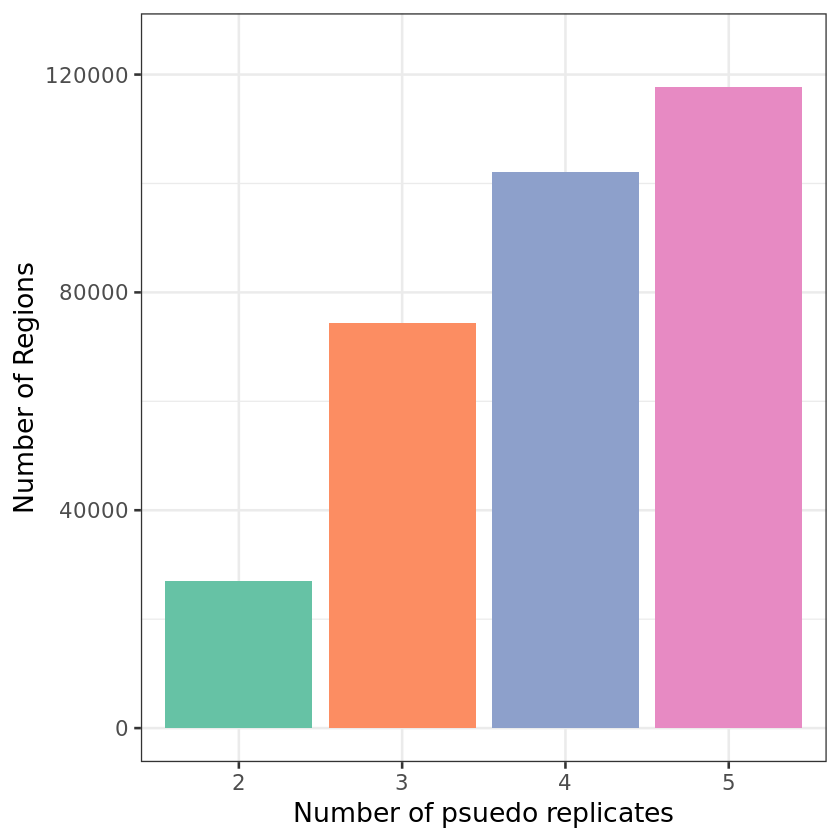

In [7]:
#Make bar plot of active region counts vs replicate number
df <- data.frame(rep_number = c(2,3,4,5), 
                 count = c(26966,74410,102041,117674))
df$rep_number <- as.factor(df$rep_number)
library(ggplot2)
library(ggsci)

p <- ggplot(df, aes(x=rep_number, y=count)) +
    geom_col(aes(fill=rep_number)) +
    theme_bw(base_family = "Arial", base_size = 16) + 
    ylab("Number of Regions") +
    xlab("Number of psuedo replicates") +
    scale_fill_brewer(palette = "Set2") +
    theme(legend.position = "none") +
    coord_cartesian(ylim = c(0,125000))


p

ggsave("/data/hodges_lab/ATAC-STARR_B-cells/results/psuedo_reps/bar_plot.pdf", plot = p, 
      device = cairo_pdf, width = 4, height = 3)